In [1]:
from text_mining import TextMining
import pandas as pd
import sys
sys.path.append('../src')
from database import get_last_data, get_collection
import os
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import networkx as nx
import itertools
import re
# from tags_dict_datascience import TAGS

In [2]:
API = os.getenv("COLLECTION_API")
df = pd.DataFrame(get_last_data(collection=API))
df.head()

,_id,title,link,tags,body,is_answered,view_count,answer_count
0,689361ce2dde3c2d6cebe40b,Using qKnowledgeGradient with SaasFullyBayesia...,https://stackoverflow.com/questions/79716022/u...,"[python, debugging, data-science, bayesian, bo...",<p>I’m trying to use qKnowledgeGradient with a...,False,88,0
1,689361ce2dde3c2d6cebe40c,Stratefied vs Random Splitting on highly categ...,https://stackoverflow.com/questions/79694850/s...,"[machine-learning, split, data-science]",<p>I am working on a machine learning model on...,True,38,1
2,689361ce2dde3c2d6cebe40d,"In &quot;statsmodels&quot; Python library, why...",https://stackoverflow.com/questions/79693109/i...,"[python, statistics, data-science, statsmodels...","<p>So to execute a z-test in python, I have se...",True,74,2
3,689361ce2dde3c2d6cebe40e,Sharing Stored Cache After Reading CSV&#39;s L...,https://stackoverflow.com/questions/79687409/s...,"[r, data-science, targets-r-package]",<p>I have 760 large csv files on which i perfo...,False,52,0
4,689361ce2dde3c2d6cebe40f,Identify a column cell and perform subtraction...,https://stackoverflow.com/questions/79684073/i...,"[python, pandas, data-science]","<p>This is just a small example DataFrame, but...",True,71,1


Text(0.5, 1.0, "Nuage de mots des 'tags'")

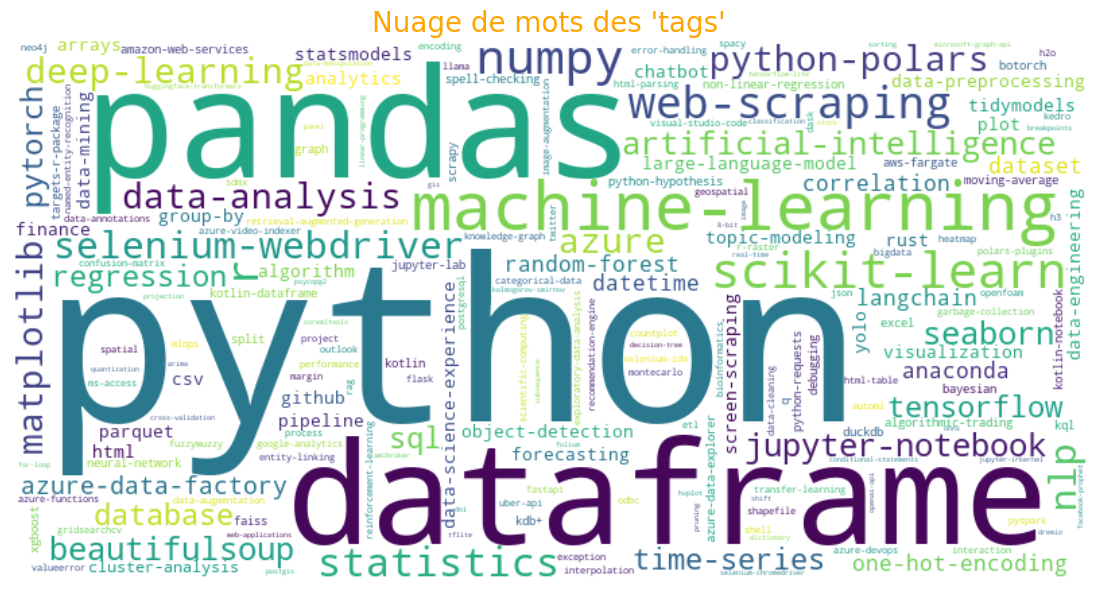

In [3]:
# supprime les chaînes vides
# all_tags = [tag for tags_list in df['tags'] for tag in tags_list if tag]
# cleaned_tags = [tag for tags_list in df['tags'] for tag in tags_list if tag and tag != 'data-science']

# Étape 1 : extraction brute
all_tags = [
    tag for tags_list in df['tags']
    for tag in tags_list if tag
]

# Étape 2 : suppression des tags non souhaités
cleaned_tags = [
    tag for tag in all_tags
    if tag != 'data-science'
]

# Étape 3 : fusion des modalités équivalentes
final_tags = [
    'python' if tag in ('python', 'python-3.x') else tag
    for tag in cleaned_tags
]




from collections import Counter
tag_counts = Counter(final_tags)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tag_counts)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Nuage de mots des 'tags'", fontsize=20, color='orange')

In [4]:
tag_counts.most_common()

[('python', 135),
 ('pandas', 46),
 ('dataframe', 40),
 ('machine-learning', 27),
 ('scikit-learn', 13),
 ('numpy', 12),
 ('r', 10),
 ('web-scraping', 10),
 ('statistics', 8),
 ('nlp', 7),
 ('selenium-webdriver', 7),
 ('deep-learning', 6),
 ('matplotlib', 6),
 ('python-polars', 6),
 ('azure', 6),
 ('data-analysis', 6),
 ('artificial-intelligence', 5),
 ('beautifulsoup', 5),
 ('jupyter-notebook', 5),
 ('seaborn', 5),
 ('pytorch', 4),
 ('sql', 4),
 ('tensorflow', 4),
 ('database', 4),
 ('time-series', 4),
 ('regression', 4),
 ('azure-data-factory', 4),
 ('anaconda', 3),
 ('correlation', 3),
 ('one-hot-encoding', 3),
 ('random-forest', 3),
 ('dataset', 3),
 ('datetime', 3),
 ('langchain', 3),
 ('statsmodels', 2),
 ('object-detection', 2),
 ('yolo', 2),
 ('html', 2),
 ('large-language-model', 2),
 ('data-engineering', 2),
 ('tidymodels', 2),
 ('csv', 2),
 ('topic-modeling', 2),
 ('rust', 2),
 ('pipeline', 2),
 ('parquet', 2),
 ('github', 2),
 ('visualization', 2),
 ('group-by', 2),
 ('data

In [5]:
# Définition des catégories de tags
langages = [
    'python', 'r', 'sql', 'julia', 'scala', 'java', 'matlab',
    'c', 'c++', 'c#', 'typescript', 'swift', 'kotlin', 'go', 'ruby', 'php', 'javascript',
    'html', 'css','rust', 'dart', 'objective-c', 'vb.net', 'perl', 'lua', 'clojure'
]
bibliotheques = [
    'pandas', 'numpy', 'scikit-learn', 'xgboost', 'lightgbm', 'keras',
    'pytorch', 'tensorflow', 'nlp', 'reactjs', 'react-native', 'spring-boot',
    'flask', 'django', 'express', 'project-reactor', 'netty', 'huggingface-transformers',
    'sentence-transformers', 'matplotlib', 'ggplot2', 'seaborn', 'shiny'
]
edi = [
    'excel', 'sas', 'visual-studio-code', 'vscode', 'pycharm',
    'visual-studio', 'rstudio', 'jupyter', 'colab', 'powerbi', 'smartsheet-api', 'tableau'
]
frameworks = [
    '.net', '.net-4.8', '.net-8.0', '.net-9.0',
    'asp.net', 'asp.net-core', 'asp.net-core-mvc', 'asp.net-mvc',
    'spring', 'spring-boot', 'spring-data-jpa', 'spring-webflux',
    'angular', 'angular-material', 'react-native', 'redux', 'vue.js', 'django',
    'flask', 'fastapi', 'svelte', 'next.js', 'rails', 'symfony'
]
outils = [
    'cmake', 'make', 'gradle', 'maven', 'webpack', 'vite', 'ninja',
    'docker', 'docker-compose', 'jenkins', 'github-actions', 'gitlab',
    'visual-studio', 'vscode', 'pycharm', 'intellij-idea', 'eclipse', 'xcode', 'clion'
]
cloud = [
    'azure', 'azure-devops', 'azure-functions', 'azure-blob-storage',
    'aws-lambda', 'amazon-web-services', 'amazon-s3', 'gcp', 'google-cloud-run',
    'kubernetes', 'kubernetes-helm', 'docker', 'terraform', 'grafana', 'prometheus'
]
plateformes = [
    'android', 'ios', 'android-studio', 'android-camera2', 'android-jetpack-navigation',
    'macos', 'windows', 'linux', 'ubuntu', 'raspberry-pi', 'tvos'
]
sgbd = [
    'sql-server', 'postgresql', 'mysql', 'sqlite', 'oracle-database',
    'db2', 'mongodb', 'firebase-realtime-database', 'influxdb', 'neo4j', 'redis'
]
concepts = [
    'data-science', 'machine-learning', 'deep-learning', 'artificial-intelligence',
    'data-analysis', 'statistics', 'regression', 'nlp', 'time-series'
]
environnements_data = [
    'jupyter-notebook', 'anaconda', 'langchain'
]
scraping = [
    'web-scraping', 'beautifulsoup', 'selenium-webdriver'
]

# Déterminer les tags restants non catégorisés
autres = set(tag_counts.keys()) - set(langages) - set(bibliotheques) - set(edi) - set(cloud) - set(plateformes) - set(sgbd) - set(outils) - set(frameworks)

# Dictionnaire des catégories
categories = {
    'Langages': langages,
    'Bibliothèques': bibliotheques,
    'Frameworks': frameworks,
    'Outils': outils,
    'Cloud': cloud,
    'Plateformes': plateformes,
    'SGBD': sgbd,
    'Concepts': concepts,
    'Environnements Data Science': environnements_data,
    'Scraping / Extraction': scraping,
    'Autres': list(autres)
}

# Filtrer les catégories utiles :
categories_utiles = {}

for k, v in categories.items():
    # Récupérer les occurrences valides
    counts = [tag_counts[tag] for tag in v if tag in tag_counts]
    # Garder si : au moins 2 tags, et fréquences différentes
    if len(counts) >= 2 and len(set(counts)) > 1:
        categories_utiles[k] = v

# Affichage du top 5 des tags pour chaque catégorie utile
for cat, tags_list in categories_utiles.items():
    print(f"\nCatégorie : {cat}")
    filtered = [(tag, tag_counts[tag]) for tag in tags_list if tag in tag_counts]
    filtered.sort(key=lambda x: x[1], reverse=True)
    for tag, count in filtered[:5]:
        print(f"{tag}: {count}")



Catégorie : Langages
python: 135
r: 10
sql: 4
html: 2
rust: 2

Catégorie : Bibliothèques
pandas: 46
scikit-learn: 13
numpy: 12
nlp: 7
matplotlib: 6

Catégorie : Cloud
azure: 6
azure-devops: 1
azure-functions: 1
amazon-web-services: 1

Catégorie : Concepts
machine-learning: 27
statistics: 8
nlp: 7
deep-learning: 6
data-analysis: 6

Catégorie : Environnements Data Science
jupyter-notebook: 5
anaconda: 3
langchain: 3

Catégorie : Scraping / Extraction
web-scraping: 10
selenium-webdriver: 7
beautifulsoup: 5

Catégorie : Autres
dataframe: 40
machine-learning: 27
web-scraping: 10
statistics: 8
selenium-webdriver: 7


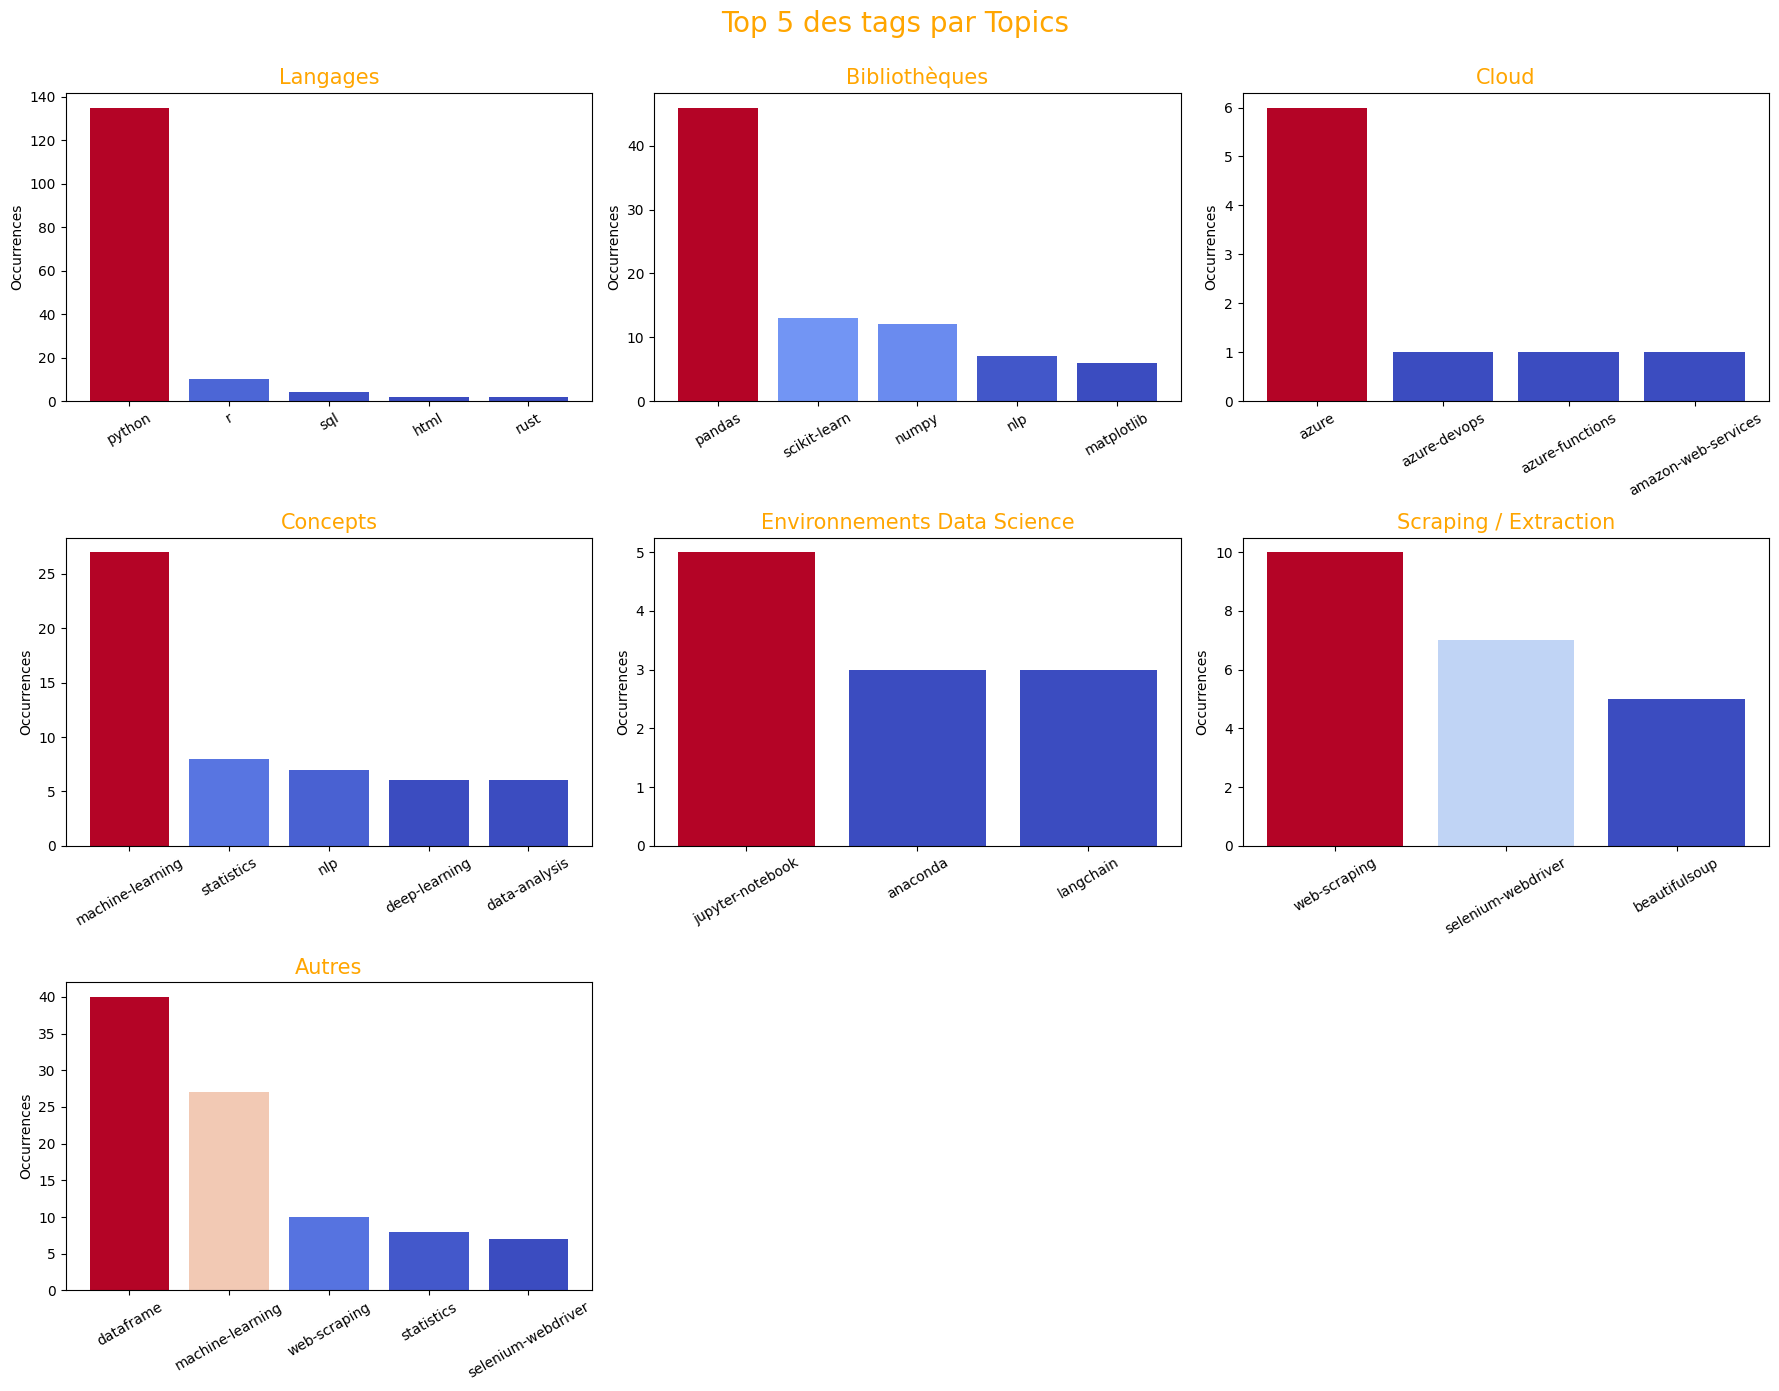

In [6]:
# Visualisation des top tags par catégorie avec dégradé rouge (max) à bleu (min) et suppression des subplots vides
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 14))
axes = axes.flatten()

plot_idx = 0
for cat, tags_list in categories_utiles.items():
    filtered = [(tag, tag_counts[tag]) for tag in tags_list if tag in tag_counts]
    filtered.sort(key=lambda x: x[1], reverse=True)
    top_tags = filtered[:5]
    if top_tags:
        tags, counts = zip(*top_tags)
        norm = plt.Normalize(min(counts), max(counts))
        colors = cm.coolwarm(norm(counts))  # coolwarm va du bleu au rouge
        # axes[plot_idx].set_facecolor('#f0f0f0')
        axes[plot_idx].bar(tags, counts, color=colors)
        axes[plot_idx].set_title(cat, color='orange', fontsize=15)
        axes[plot_idx].set_ylabel('Occurrences')
        axes[plot_idx].tick_params(axis='x', rotation=30)
        plot_idx += 1

# Masquer les subplots restants (non utilisés)
for ax in axes[plot_idx:]:
    ax.set_visible(False)

plt.tight_layout(rect=[0, 0.03, 1, 0.99])
plt.suptitle("Top 5 des tags par Topics", fontsize=20, color='orange', y=1.02)
plt.show()

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'python'),
  Text(1, 0, 'pandas'),
  Text(2, 0, 'dataframe'),
  Text(3, 0, 'machine-learning'),
  Text(4, 0, 'scikit-learn'),
  Text(5, 0, 'numpy'),
  Text(6, 0, 'web-scraping'),
  Text(7, 0, 'r'),
  Text(8, 0, 'statistics'),
  Text(9, 0, 'nlp')])

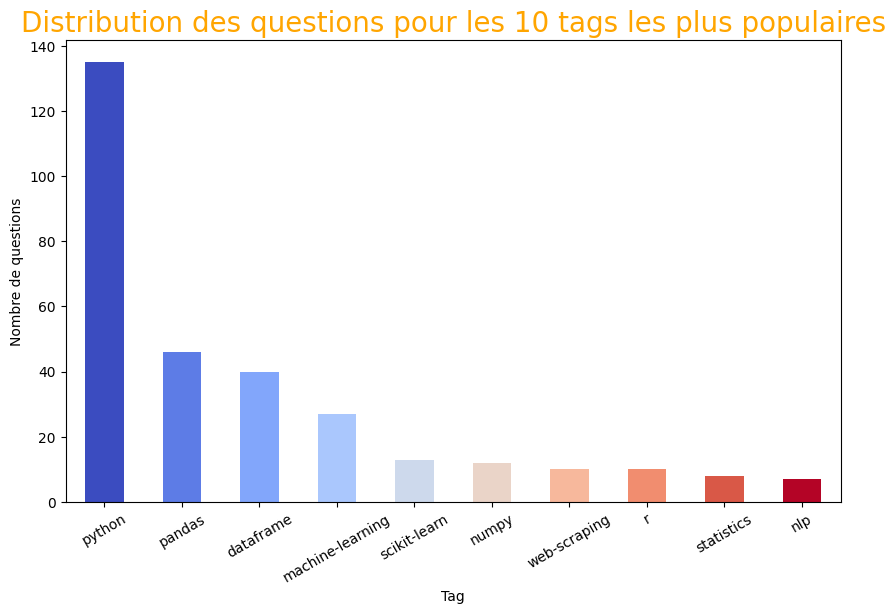

In [7]:
# Extraction des mots-clés les plus fréquents dans les titres
title_words = []
for title in df['title']:
    words = re.findall(r'\b\w+\b', title.lower())
    title_words.extend(words)

stopwords = set(['the', 'a', 'an', 'and', 'or', 'to', 'of', 'in', 'on', 'for', 'with', 'is', 'how', 'can', 'by', 'from', 'at', 'it', 'as', 'be', 'are', 'this', 'that', 'i', 'my', 'but', 'if', 'do', 'does', 'using', 'use', 'when', 'what', 'which', 'not', 'so', 'about', 'after', 'why', 'you', 'we', 'me', 'your', 'was', 'will', 'all', 'any', 'has', 'have', 'had', 'get', 'got', 'would', 'should', 'could', 'just', 'also', 'more', 'some', 'than', 'then', 'there', 'their', 'them', 'its', 'into', 'out', 'up', 'down', 'over', 'under', 'between', 'before', 'been', 'being', 'were', 'did', 'does', 'doing', 'may', 'might', 'must', 'shall', 'such', 'like', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten'])
filtered_words = [w for w in title_words if w not in stopwords and len(w) > 2]
Counter(filtered_words).most_common(20)

# Détection de thèmes ou sujets récurrents dans les résumés
summary_words = []
for summary in df['body']:
    words = re.findall(r'\b\w+\b', summary.lower())
    summary_words.extend(words)
filtered_summary_words = [w for w in summary_words if w not in stopwords and len(w) > 2]
Counter(filtered_summary_words).most_common(20)

# Visualiser la distribution des questions pour les tags les plus populaires
import matplotlib.pyplot as plt
popular_tags = pd.Series(final_tags).value_counts().head(10)
plt.figure(figsize=(10,6))
popular_tags.plot(kind='bar', color=cm.coolwarm(np.linspace(0,1,10)))
plt.xlabel('Tag')
plt.ylabel('Nombre de questions')
plt.title('Distribution des questions pour les 10 tags les plus populaires', fontsize=20, color='orange')
plt.xticks(rotation=30)

In [8]:
def build_clean_text(self, output_column="clean_text"):
    self.df[output_column] = self.df[self.token_column].apply(lambda tokens: " ".join(tokens))
    return self

In [9]:
tm_body = TextMining(df, text_column="body", tokens_column="tokens_body")
df = (
    tm_body.lowercase()
            .decode_html()  
            .remove_accents()
            .extract_url()
            .clean_regex(["body"])
            .tokenize()
            .remove_stopwords()
            .remove_short_tokens(min_len=3)
            .remove_long_tokens(max_len=20)
            .remove_numeric_tokens()
            .remove_custom_noise()
            .remove_repeated_tokens()
            .remove_tokens_starting_with_html_custom()  
            .apply_lemmatizer()
            .build_clean_text("clean_body")
            .get_df()
)

tm_title = TextMining(df, text_column="title", tokens_column="tokens_title")
df = (
    tm_title.lowercase()
            .decode_html() 
            .remove_accents()
            .extract_url()
            .clean_regex(["title"])
            .tokenize()
            .remove_stopwords()
            .remove_short_tokens(min_len=3)
            .remove_long_tokens(max_len=20)
            .remove_numeric_tokens()
            .remove_custom_noise()  
            .remove_repeated_tokens()
            .remove_tokens_starting_with_html_custom()  
            .apply_lemmatizer()
            .build_clean_text("clean_title")
            .get_df()
)

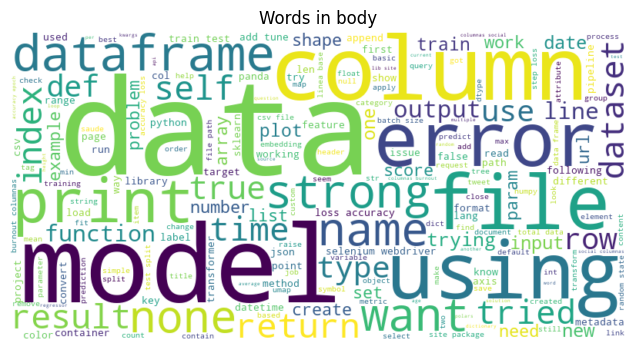

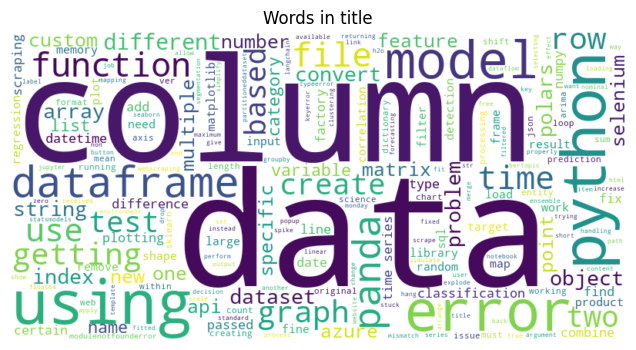

In [10]:
body = " ".join(df["clean_body"].dropna())
title = " ".join(df["clean_title"].dropna())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(body)
plt.figure(figsize=(10, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Words in body")
plt.show()

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(title)
plt.figure(figsize=(10, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Words in title")
plt.show()


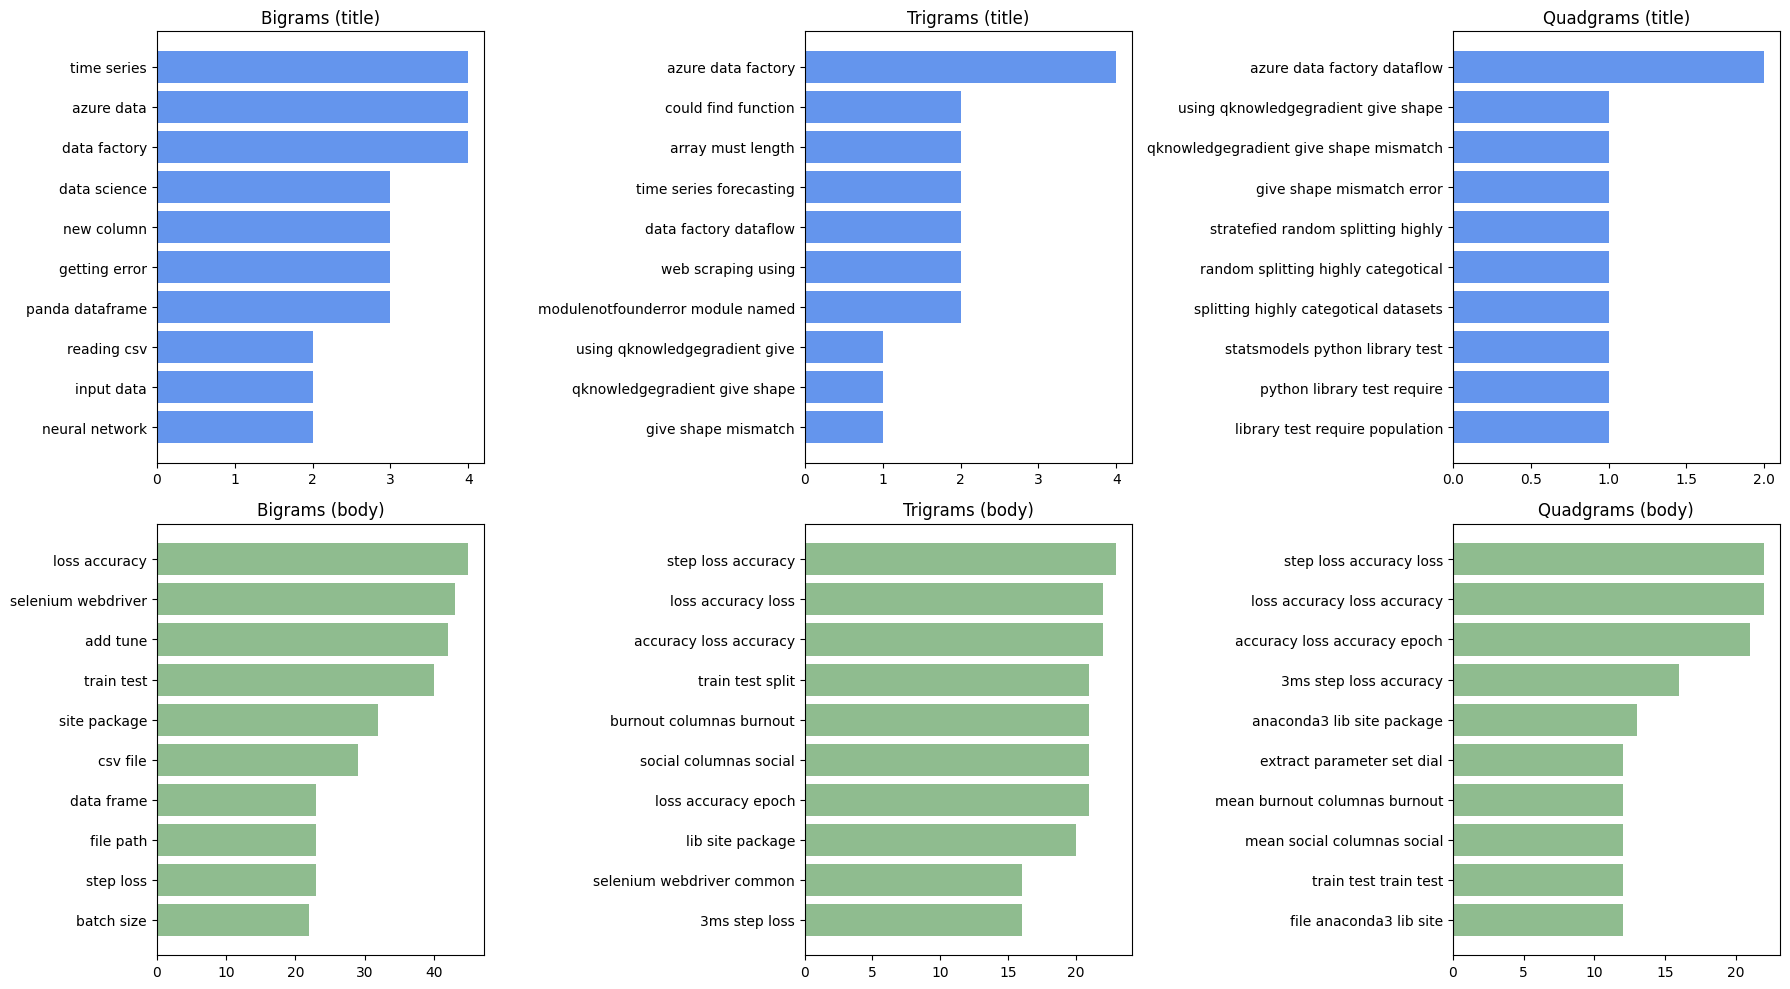

In [11]:
text_title = df["clean_title"].dropna().astype(str).tolist()
text_body = df["clean_body"].dropna().astype(str).tolist()

def plot_ngrams(corpus, n, color, title):
    vectorizer = CountVectorizer(ngram_range=(n, n))
    X = vectorizer.fit_transform(corpus)
    sums = X.sum(axis=0)
    freqs = [(word, sums[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    freqs = sorted(freqs, key=lambda x: x[1], reverse=True)[:10]

    words, counts = zip(*freqs)
    plt.barh(words, counts, color=color)
    plt.title(title)
    plt.gca().invert_yaxis()

plt.figure(figsize=(18, 10))

plt.subplot(2, 3, 1)
plot_ngrams(text_title, 2, 'cornflowerblue', "Bigrams (title)")
plt.subplot(2, 3, 2)
plot_ngrams(text_title, 3, 'cornflowerblue', "Trigrams (title)")
plt.subplot(2, 3, 3)
plot_ngrams(text_title, 4, 'cornflowerblue', "Quadgrams (title)")

plt.subplot(2, 3, 4)
plot_ngrams(text_body, 2, 'darkseagreen', "Bigrams (body)")
plt.subplot(2, 3, 5)
plot_ngrams(text_body, 3, 'darkseagreen', "Trigrams (body)")
plt.subplot(2, 3, 6)
plot_ngrams(text_body, 4, 'darkseagreen', "Quadgrams (body)")

plt.tight_layout()
plt.show()


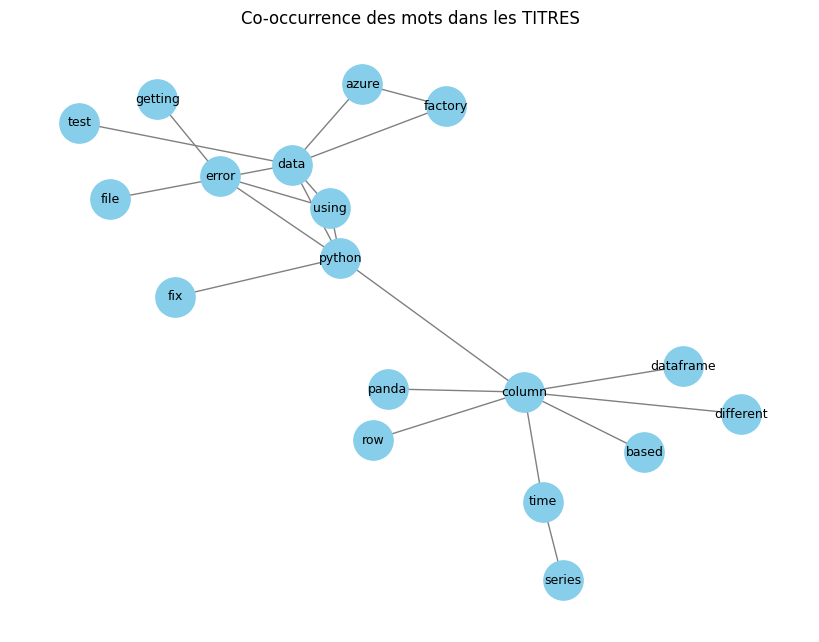

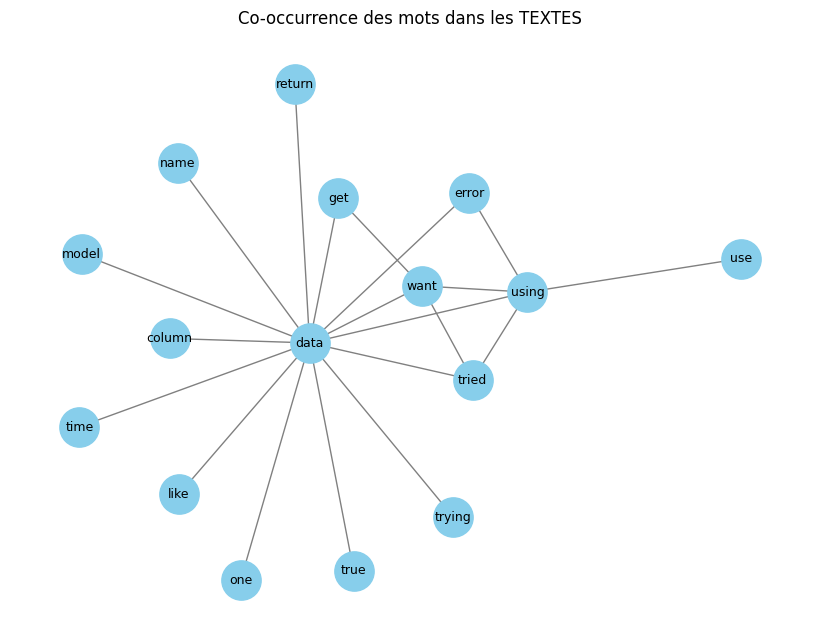

In [12]:
# S'assurer que les colonnes sont bien des listes
for col in ["tokens_title", "tokens_body"]:
    df[col] = df[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

def cooc_graph(df_subset, token_column="tokens", max_edges=20, title="Co-occurrence"):
    cooc = Counter()
    for tokens in df_subset[token_column].dropna():
        tokens = eval(tokens) if isinstance(tokens, str) else tokens  # sécurité si string
        unique_tokens = set(tokens)
        for a, b in itertools.combinations(sorted(unique_tokens), 2):
            cooc[(a, b)] += 1

    cooc_df = pd.DataFrame(cooc.items(), columns=["pair", "count"])
    cooc_df = cooc_df.sort_values(by="count", ascending=False).head(max_edges)

    # Graphe
    G = nx.Graph()
    for (a, b), count in cooc_df.values:
        G.add_edge(a, b, weight=count)

    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G, k=0.7, seed=42)
    nx.draw(G, pos, with_labels=True, node_size=800, node_color="skyblue", edge_color="gray", font_size=9)
    plt.title(title)
    plt.axis('off')
    plt.show()

# === Graphe pour title et body ===
cooc_graph(df, token_column="tokens_title", title="Co-occurrence des mots dans les TITRES")
cooc_graph(df, token_column="tokens_body", title="Co-occurrence des mots dans les TEXTES")
